In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip


In [2]:
import seaborn as sns                                                  #for plotting
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

# Train test split
from sklearn.model_selection import train_test_split                  #divide the data in train test and validation set.

# Text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

# Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, Bidirectional

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
#save train dataframe
train_df = pd.read_csv("/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip")
sample_df = train_df.sample(frac=0.5, random_state=42)               #sampling for testing model at start

In [4]:
train_df = sample_df

In [5]:
#train df shape
train_df.shape

(79786, 8)

In [6]:
#save test dataframe
# test_df = pd.read_csv("/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip")
# test_df.shape

In [7]:
# sample_test = test_df.sample(frac=0.1, random_state=42)   

In [8]:
# test_df = sample_test

In [9]:
#counting classes and their occurences with labels
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train_df[class_names].apply(lambda x: x.value_counts())

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,72119,78979,75559,79556,75822,79079
1,7667,807,4227,230,3964,707


In [10]:
# Normalize
train_df[class_names].apply(lambda x: x.value_counts(normalize=True))

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0.903905,0.989885,0.947021,0.997117,0.950317,0.991139
1,0.096095,0.010115,0.052979,0.002883,0.049683,0.008861


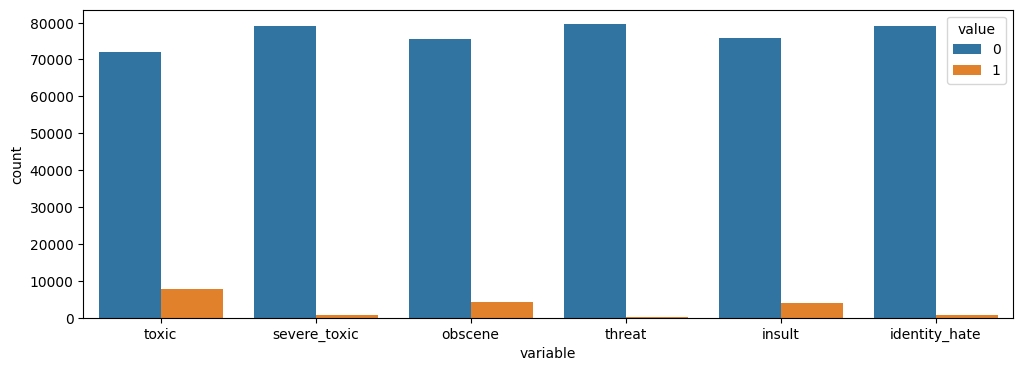

In [11]:
#plotting the classes 
plt.figure(figsize=(12,4))
sns.countplot(x="variable", hue="value", data=pd.melt(train_df[class_names]))

plt.show()

In [12]:
import nltk
# nltk.download('stopwords')
import re
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
#english = language param
snow_stemmer = SnowballStemmer(language='english')
#conversion to lowercase, split and stemming of words of ach row in dataframe
def clean( t):
    res = re.sub('[^a-zA-Z]',' ',t)
    res = res.lower()          
    res = res.split()    
    res = [snow_stemmer.stem(word) for word in res if not word in set(stopwords.words('english'))]
    res = ' '.join(res) 
    return res
    
   

In [13]:
#applying above clean function to train dataframe to clean it
train_df['comment_text'] = train_df['comment_text'].apply(lambda x: clean(x))
train_df.sample(1)['comment_text'].values[0]

'constitut challeng david kernel case list redirect discuss editor ask discuss address redirect constitut challeng david kernel case sinc involv constitut challeng david kernel case redirect might want particip redirect discuss alreadi done talk'

In [14]:
#applying above clean function to test dataframe to clean it
# test_df['comment_text'] = test_df['comment_text'].apply(lambda x: clean(x))
# test_df.sample(1)['comment_text'].values[0]

In [15]:
# parameters
# max_len = 50 
trunc_type = 'post'
padding_type = 'post'
oov_tok = 'UNK' # out of vocabulary token

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer          #importing tokenizer from tensorflow
tokenizer = Tokenizer(num_words=1000, oov_token = oov_tok)         #tokenizer object
tokenizer.fit_on_texts(train_df['comment_text'])                   # Fit the tokenizer on the training set's comment text  

X = tokenizer.texts_to_sequences(train_df['comment_text'])     # Convert the training set's comment text to sequences using above fitted tokenizer

vocab_size = len(tokenizer.word_index)+1                          #vocabulary size
vocab_size

86854

In [17]:
n = max([len(t) for t in X])           #finding out the maximum length sentence from dataframe
n

1250

In [18]:
Y = np.array(train_df.iloc[:,2:])                         #separating the labels 
Y.shape

(79786, 6)

In [19]:
Y[0:5]                                  #labels

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [20]:
print(X[0], Y[0])                      #comment text in numerical data and its labels

[1, 1, 176, 34, 1, 1, 206, 32, 7, 65, 1, 1, 312, 1, 1, 1, 1, 17, 266, 24, 23, 280, 1, 1, 251, 742, 1, 11, 82, 1] [0 0 0 0 0 0]


In [21]:
# tokenizer.fit_on_texts(test_df['comment_text'])                      #using the same tokenizer to fit on testing data

# X_test = tokenizer.texts_to_sequences(test_df['comment_text'])

In [22]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [23]:
training_padded = pad_sequences(x_train,                                    #padding training and testing data so that they are of equal length
                                maxlen=50,                             #maximum length set to 50
                                truncating=trunc_type,                 #if data to be truncated , length is more then 50 then do it post
                                padding=padding_type                   #if less data, padd it from post
                               )
testing_padded = pad_sequences(x_test,
                            maxlen=50,                               #maximum length set to 50
                            truncating=trunc_type,                   #if data to be truncated , length is more then 50 then do it post
                            padding=padding_type                    #if less data, padd it from post
                               )

In [24]:
from tensorflow.keras import models                  #importing models and layers from tensorflow
from tensorflow.keras import layers
# from tensorflow.keras import losses
lstm_dim = 32
model_bilstm = models.Sequential()
model_bilstm.add(layers.Embedding(vocab_size, 512, input_length=50))     #convert each token into dense vector
model_bilstm.add(layers.Bidirectional(layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))   #processes forward and backward keeping context
model_bilstm.add(layers.Flatten())                                        #flattening output
model_bilstm.add(layers.Dense(16, activation='relu'))                     #convert -ve to 0 
model_bilstm.add(layers.Dense(6, activation='sigmoid'))                   #squashing between 0 and 1


model_bilstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])    #assign greater val to correct class
model_bilstm.summary()                                #print model summary

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 512)           44469248  
                                                                 
 bidirectional (Bidirectiona  (None, 50, 256)          656384    
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 dense (Dense)               (None, 16)                204816    
                                                                 
 dense_1 (Dense)             (None, 6)                 102       
                                                                 
Total params: 45,330,550
Trainable params: 45,330,550
Non-trainable params: 0
____________________________________________

In [25]:
# from tensorflow.keras import models
# from tensorflow.keras import layers
# from tensorflow.keras import losses
# model = models.Sequential()
# model.add(layers.Embedding(vocab_size, 128, input_length=50))
# model.add(layers.LSTM(512, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
# model.add(layers.LSTM(128, dropout=0.2,recurrent_dropout=0.2))
# model.add(layers.Dense(16, activation='relu'))
# model.add(layers.Dense(6, activation='sigmoid'))

# model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])    #assign greater val to correct class
# model.summary()     

In [26]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

In [27]:
history = model_bilstm.fit(training_padded,              #storing the model statistics in history
                     Y,                                  #can retrieve metrics at each epoch
                    epochs=5,
                    batch_size=512,
                   validation_split=0.2,
                    callbacks=[early_stopping])

Epoch 1/5
100/100 [==============================] - 56s 494ms/step - loss: 0.1683 - accuracy: 0.9129 - val_loss: 0.1464 - val_accuracy: 0.9942
Epoch 2/5
100/100 [==============================] - 45s 451ms/step - loss: 0.1412 - accuracy: 0.9940 - val_loss: 0.1465 - val_accuracy: 0.9940
Epoch 3/5
100/100 [==============================] - 43s 430ms/step - loss: 0.1403 - accuracy: 0.9903 - val_loss: 0.1471 - val_accuracy: 0.9939


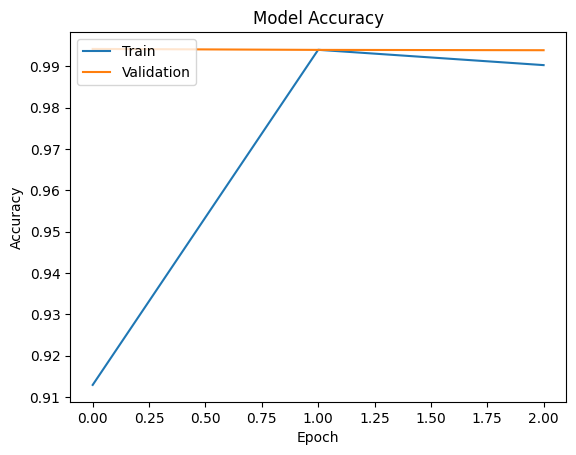

In [28]:
plt.plot(history.history['accuracy'])                                  #plot train and validation accuracy
plt.plot(history.history['val_accuracy'])              
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [29]:
# ids = test_df['id']
y_pred = model_bilstm.predict(testing_padded)                            #predicitng test dataset

499/499 [==============================] - 13s 26ms/step


In [30]:
y_pred                                     #predicted output shape

array([[0.11198849, 0.01321297, 0.05463317, 0.00312016, 0.0489    ,
        0.01103202],
       [0.11071977, 0.01349155, 0.06120518, 0.00355241, 0.05404074,
        0.01186652],
       [0.0978429 , 0.01132719, 0.05350631, 0.00268067, 0.04853576,
        0.0093375 ],
       ...,
       [0.09964445, 0.01146682, 0.05623504, 0.00291391, 0.05048406,
        0.00996271],
       [0.10236116, 0.0115248 , 0.05416737, 0.00283567, 0.0483981 ,
        0.0098266 ],
       [0.09518573, 0.01070168, 0.05342834, 0.00269627, 0.04886015,
        0.00906876]], dtype=float32)

In [31]:
final_preds = np.where(y_pred > 0.5, 1, 0)

In [32]:
final_preds

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [33]:
y_test

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [34]:
print(y_test.dtype)
print(final_preds.dtype)


int64
int64


In [36]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# print(confusion_matrix(y_val,y_pred))  
# print(classification_report(y_test,final_preds))  
print("accuracy score", accuracy_score(y_test, final_preds))

accuracy score 0.9001127960897356


In [ ]:
# pred = pd.DataFrame()
# label = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
# pred[label] = preds
# pred

In [ ]:
# submission = pd.DataFrame()                                   #concatinating test df id and predicted labels
# submission['id']= ids
# label = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
# submission[label]= preds
# submission

In [ ]:
# submission.to_csv('/kaggle/working/submission.csv', index=False)                   #submission file